In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
# from concept_helpers.concept_deepview import DeepViewConcept
# from xplique.concepts import CraftTorch as Craft
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.DeepView_Craft import CraftTorchSupervisedShared as CraftSS
from concept_helpers.DeepView_Craft import CraftTorchSupervised as CraftS
from concept_helpers.combined_crafts import CombinedCrafts , CraftSAE
from xplique.attributions.global_sensitivity_analysis import HaltonSequenceRS, JansenEstimator

from xplique.concepts.craft_torch import _batch_inference

import urllib.request
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import timm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse.linalg import eigs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, adjusted_rand_score, rand_score,
                            normalized_mutual_info_score, adjusted_mutual_info_score)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from concept_helpers.disc_nmf import RSNMF

from sklearn.cluster import KMeans
import random
import torchvision.transforms.functional as F
import random
from DriftLocalization.j_helper_functions import uncertainty_matrices, entropy_uncertainty

from experiment_helpers.experiment_helper_functions import *

# from deepview.evaluate import evaluate_umap
# from deepview.evaluate import leave_one_out_knn_dist_err


device = 'cuda' 
# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)
# train_images, train_labels, val_images, val_labels, model = load_imagenette()

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
# g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
# h = nn.Sequential(*(list(model.children())[4:]))  # penultimate layer to logits

g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
h = nn.Sequential(*(list(model.children())[4:]))
# classifier_head = ClassifierHead(in_features=2048, out_features=10)
# classifier_head = classifier_head.to(device)
# classifier_head.load_state_dict(torch.load("models/imagewoof_classifier_head.pth"))

# with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
#     imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))


def gen_images(filelist):
    for f in filelist:
        folder_name = f.split('/')[-2]
        class_id = folder_name2class_id[folder_name]
        im = Image.open(f)
        if len(im.getbands()) == 3:
            yield np.array(im.resize((224, 224))), class_id
# # Load imagenette dataset
# imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)

# folders_names = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601',
#                  'n02105641', 'n02111889', 'n02115641']

# imagewoof_class_names = ['Shih-Tzu', 'Rhodesian ridgeback', 'beagle', 'English foxhound', 'Border terrier',
#                               'Australian terrier', 'golden retriever', 'Old English sheepdog', 'Samoyed', 'dingo']

# # Map folder names to ImageNet class IDs
# imagewoof_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in imagewoof_class_names]
# folder_name2class_id = dict(zip(folders_names, imagewoof_class_ids))


# # Get file lists for train, val, and test sets
# # train_filelist = glob.glob(f'{imagewoof_folder}/train/*/*.JPEG')
# val_filelist = glob.glob(f'{imagewoof_folder}/val/*/*.JPEG')
# # test_filelist = glob.glob(f'{imagenette_folder}/test/*/*.JPEG')

# # Preprocess train, validation, and test sets in batches
# # train_images, train_labels = preprocess_images_in_batches(train_filelist)
# val_images, val_labels = preprocess_images_in_batches(val_filelist,gen_images, transform, to_pil)


from fastai.data.external import untar_data, URLs

# Load ImageNet class names
with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
    imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))

def get_validation_set_for_random_classes(preprocess_fn, gen_images, transform, to_pil, seed=None):
    """
    Randomly selects 10 classes from Imagewoof and Imagenette, retrieves their validation images and labels.

    Args:
        preprocess_fn (function): Function to preprocess images in batches.
        gen_images: Data generator function.
        transform: Transform function for images.
        to_pil: Function to convert images to PIL format.
        seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
        val_images (list): Preprocessed validation images for the selected classes.
        val_labels (list): Corresponding class labels (ImageNet indices).
        selected_classes (list): Names of the 10 randomly selected classes.
    """

    if seed is not None:
        random.seed(seed)
    
    def gen_images(filelist):
        for f in filelist:
            folder_name = f.split('/')[-2]
            class_id = folder_name2class_id[folder_name]
            im = Image.open(f)
            if len(im.getbands()) == 3:
                yield np.array(im.resize((224, 224))), class_id

    # Download datasets
    imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)
    imagenette_folder = untar_data(URLs.IMAGENETTE_160)

    # Define Imagewoof class mappings
    imagewoof_folders = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 
                          'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']
    imagewoof_names = ['Shih-Tzu', 'Rhodesian ridgeback', 'beagle', 'English foxhound', 'Border terrier',
                       'Australian terrier', 'golden retriever', 'Old English sheepdog', 'Samoyed', 'dingo']
    
    imagenette_folders = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                           'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
    imagenette_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
                        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
    
    # Get ImageNet class IDs
    imagewoof_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in imagewoof_names]
    imagenette_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in imagenette_names]

    # Combine all classes
    all_folders = imagewoof_folders + imagenette_folders
    all_class_names = imagewoof_names + imagenette_names
    all_class_ids = imagewoof_class_ids + imagenette_class_ids
    
    # Create folder name to class ID mapping
    folder_name2class_id = dict(zip(all_folders, all_class_ids))
    
    # Randomly select 10 classes
    selected_indices = random.sample(range(20), 10)
    selected_folders = [all_folders[i] for i in selected_indices]
    selected_class_names = [all_class_names[i] for i in selected_indices]
    selected_class_ids = [all_class_ids[i] for i in selected_indices]  # Ensure correct ImageNet labels

    # Collect validation file paths
    val_filelist = []
    for folder in selected_folders:
        val_filelist.extend(glob.glob(f'{imagewoof_folder}/val/{folder}/*.JPEG'))
        val_filelist.extend(glob.glob(f'{imagenette_folder}/val/{folder}/*.JPEG'))

    # Process images and labels
    val_images, val_labels = preprocess_fn(val_filelist, gen_images, transform, to_pil)

    return val_images, val_labels, selected_class_names, selected_class_ids





def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

# ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
# # ood_folder = '/home/iroberts/projects/concepts_deepview/data/NINCO_all/NINCO/NINCO_popular_datasets_subsamples'

# ood_folder_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey_fox', 'Arctic_fox']
# ood_class_names = ['french_fries','donuts','waffles','glass_of_milk','cup_cakes','chicken_quesadilla']#, 'donuts'] #'grey fox', 'Arctic fox']

ood_folder = '/home/robertsi20/PycharmProjects/Concepts/concepts_deepview/data/NINCO/NINCO_OOD_classes'
# '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
# '/home/iroberts/projects/concepts_deepview/data/drift_detection'
        
ood_folder_names = os.listdir(ood_folder)
ood_class_names = ood_folder_names

ood_class_ids = [i+1000 for i,class_name in enumerate(ood_class_names)]
ood_folder_name2class_id = dict(zip(ood_folder_names, ood_class_ids))
ood_filelist = glob.glob(f'{ood_folder}/*/*.jpg')
# print(ood_filelist)

ood_images, ood_labels = zip(*gen_images(ood_filelist,ood_folder_names,ood_folder_name2class_id))
ood_images, ood_labels = np.array(ood_images), np.array(ood_labels)
ood_preprocessed_images = torch.stack([transform(to_pil(img)) for img in ood_images], 0)

def full_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor)
        pred = h(latent).cpu().numpy()
    return pred
    
def latent_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor).cpu().numpy()
            # pred = h(tensor).cpu().numpy()
    return latent

def process_in_batches(data, batch_size, func):
    """
    Process data in batches using the full_wrapper function.

    Args:
        data (np.ndarray): Input data to process.
        batch_size (int): Size of each batch.

    Returns:
        np.ndarray: Predictions for the entire dataset.
    """
    # Initialize an empty list to store predictions
    all_preds = []

    # Iterate over the data in batches
    for start_idx in range(0, len(data), batch_size):
        # Get the end index for the current batch
        end_idx = min(start_idx + batch_size, len(data))
        # Get the current batch
        batch = data[start_idx:end_idx]
        # Use full_wrapper to process the batch and get predictions
        batch_preds = func(batch)
        # Append the predictions to the list
        all_preds.append(batch_preds)

    # Concatenate all batch predictions into a single numpy array
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds
    
def predict_with_uncertainty_batched(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs,_ in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)

from sklearn.decomposition import non_negative_factorization


def predict_with_uncertainty_batched_sig(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)
    

def compute_predictions_sigmoid(inputs):
    # tree_predictions = []
    # for tree in model.estimators_:
    #     tree_predictions.append(tree.predict_proba(inputs))
    
    # tree_predictions = np.array(tree_predictions)
    
    # embeddings = process_in_batches(preprocessed_images,32, latent_wrapper,g).to(device)
    inputs = inputs.to(device)
    data_loader = torch.utils.data.DataLoader(inputs, batch_size=64)
    
    predictions = predict_with_uncertainty_batched_sig(stochastic_model, data_loader, n_iter=20, device=device)

    predictions =  predictions.cpu().numpy()
    
    a,prob_mat = uncertainty_matrices(predictions)
    t,e,a = entropy_uncertainty(prob_mat)
    sig_threshold, _, t_norm = get_threshold(t)
    loc = UncertaintyWrapperWithSigmoid(sig_threshold)

    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    return unc_preds, unc_pred_probs


def nmf_transform(inputs,drift_basis, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
   
    # Step 1: Extract latent activations using drift_craft
    A = np.mean(inputs, axis=(1,2))#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
   # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    # original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    # re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    embedding, basis, n_iter = non_negative_factorization(A,
                                                          n_components=len(drift_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=drift_basis)
    # print(embedding.shape)
    

    return embedding




2025-02-24 11:09:00.769787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 11:09:00.779009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740391740.790466  820727 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740391740.793950  820727 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 11:09:00.805708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [2]:
from tqdm import tqdm
# Initialize a dictionary to store results
results = defaultdict(lambda: defaultdict(dict))
auc_results = defaultdict(lambda: defaultdict(dict))

# Run multiple times and collect results

for i in tqdm(range(1)):

    val_images, val_labels, selected_classes, selected_ids = get_validation_set_for_random_classes(
    preprocess_images_in_batches, gen_images, transform, to_pil,seed=None)
    
    ood_sample = np.random.choice(len(ood_preprocessed_images),200,False)
    sample_ood_preprocessed_images = ood_preprocessed_images[ood_sample]
    sample_ood_labels = ood_labels[ood_sample]
    
    sample = np.random.choice(len(val_images),300,False )
    sample_val_images = val_images[sample]
    sample_val_labels = val_labels[sample]
    

    

    
    # Step 3: Concatenate IID and OOD data
    idd_embeddings = process_in_batches(sample_val_images, 64, latent_wrapper)
    
    ood_embeddings = process_in_batches(sample_ood_preprocessed_images, 64, latent_wrapper)
    
    all_embeddings = torch.cat([torch.from_numpy(idd_embeddings),torch.from_numpy(ood_embeddings)]).to(device)
    all_images = torch.cat([sample_val_images, sample_ood_preprocessed_images]).to(device)
    all_labels = torch.from_numpy(np.concatenate([sample_val_labels, sample_ood_labels])).to(device)
    
    # Step 5: Shuffle all data while keeping track of noise
    shuffle_indices = torch.randperm(all_images.shape[0])
    
    shuffled_embeddings = all_embeddings[shuffle_indices]
    shuffled_images = all_images[shuffle_indices]
    shuffled_labels = all_labels[shuffle_indices]
    
    idd_odd_og_labels = shuffled_labels.cpu().numpy()
    
    
    ood_ind = np.where(idd_odd_og_labels > 999)[0]
    idd_ind = np.where(idd_odd_og_labels <= 999)[0]
    
    idd_odd_labels = idd_odd_og_labels.copy()
    idd_odd_labels[ood_ind] = np.random.choice(np.unique(val_labels), size=len(ood_ind))
    # gt_idd_ood = idd_odd_og_labels.copy()
    # gt_idd_ood[ood_ind] = 1
    # gt_idd_ood[idd_ind] = 0
    
    
    idd_odd_labels = torch.from_numpy(idd_odd_labels).to(device)
    dataset = EmbeddingDataset(shuffled_embeddings,idd_odd_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
    
    # Create stochastic model
    dropout_prob = 0.5
    stochastic_model = StochasticModel(h, dropout_prob).to(device)
    
    
    predictions = predict_with_uncertainty_batched(stochastic_model.to(device), dataloader, n_iter=30)
    predictions = predictions.cpu().numpy()
    
    
    prediction_list, prob_mat = uncertainty_matrices(predictions)
    t, e, a = entropy_uncertainty(prob_mat)
    
    threshold, _, t_norm = get_threshold(t)
    
    loc = UncertaintyWrapperWithSigmoid(threshold)
    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    
    low_indices = np.where(unc_preds == 0)[0]
    med_indices = np.where(unc_preds == 1)[0]
    
    patch_size=80
    
    
    med_fit = Craft(input_to_latent_model=g,
                        latent_to_logit_model=h,
                        number_of_concepts=20,
                        # labels=h_y,
                        patch_size=patch_size,
                        batch_size=64,
                        device=device)
    print("Fitting Unsupervised Craft....")
    med_crops, med_crops_u, med_w = med_fit.fit(shuffled_images[med_indices])

    low_fit = Craft(input_to_latent_model=g,
                            latent_to_logit_model=h,
                            number_of_concepts=55,
                            # labels=h_y,
                            patch_size=patch_size,
                            batch_size=64,
                            device=device)
    print("Fitting Unsupervised Craft....")
    low_crops, low_crops_u,low_w = low_fit.fit(shuffled_images[low_indices])
    
    unc_basis = np.vstack([low_w,med_w])
    
    
    sigmoidunc_craft = CombinedCrafts(input_to_latent_model=g,
                    latent_to_logit_model=stochastic_model,
                    number_of_concepts=len(unc_basis),
                    inputs=shuffled_images,
                    labels=unc_preds,
                    basis = unc_basis,
                    batch_size=64,
                    patch_size=patch_size,
                    device=device)
    print("Fitting Craft....")
    sigmoidunc_craft.transform_all()
    
    
    # y_preds_sig, _ = compute_predictions_sigmoid(shuffled_embeddings)
        
    # sig_imp, sig_im_imp = estimate_importance_sigmoid(sigmoidunc_craft,compute_predictions_sigmoid,unc_basis,shuffled_embeddings)
    
    # sig_im_imp = np.array([estimate_importance_helper_sigmoid(sigmoidunc_craft,compute_predictions_sigmoid,unc_basis,
    #     torch.unsqueeze(image,dim=0),class_of_interest=y_preds_sig[i]) for i,image in enumerate(shuffled_embeddings)])
    
    sig_im_nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).permute((0,2,3,1)).cpu().numpy(),unc_basis) 
                               for i,image in enumerate(shuffled_embeddings)])
    sig_im_nmf_act =  sig_im_nmf_act.reshape((len(sig_im_nmf_act), sig_im_nmf_act.shape[2]))

    unc_imp_val = np.mean(sig_im_nmf_act[med_indices], axis=0)
    cer_imp_val = np.mean(sig_im_nmf_act[low_indices], axis=0)
    unc_imp = np.argsort(unc_imp_val)[::-1]
    cer_imp = np.argsort(cer_imp_val)[::-1]

    for k,vals in enumerate([cer_imp_val,unc_imp_val]):
        most_important_concepts = np.argsort(vals)[::-1]
        sigmoidunc_craft.sensitivities[k] = Sensitivity(vals, most_important_concepts,
                                                                      cmaps=plt.get_cmap('tab20b').colors
                                                                            + plt.get_cmap('Set3').colors +
                                                                            plt.get_cmap('tab20c').colors +
                                                                            plt.get_cmap('tab10').colors +
                                                                            plt.get_cmap('tab20').colors +
                                                                            plt.get_cmap('Set1').colors +
                                                                            plt.get_cmap('Set2').colors)
    
    _, y_preds_sig = compute_predictions_sigmoid(shuffled_embeddings)
    
    
    t_acc, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                           idd_odd_labels,
                                                           t, 
                                                           plot=False, 
                                                           plot_name= "test")
    try: 
        e_acc, _, _, _ , steps = accuracy_rejection(prediction_list, 
                                                                idd_odd_labels,
                                                                e, 
                                                                plot=False, 
                                                                plot_name= "test")
        
        a_acc, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                                idd_odd_labels,
                                                               a, 
                                                               plot=False, 
                                                               plot_name= "test")
    except:
        e_acc = None
        a_acc = None
        
    
    sig_preds_acc, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           y_preds_sig[:,1], 
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 1
    # sig_local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    # sig_local_softactpreds = np.array(local_imp_concepts_globally_lsoft(sigmoidunc_craft,nmf_activations ,num,y_preds_sig))
    num = 1
    # sig_local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
   
    num = 2
    # sig_2local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_2local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))

    num=2
    # sig_2local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_2local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    
    num = 3
    # sig_3local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    num=3
    # sig_3local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    

    # one_local_soft_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_local_softimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    one_local_soft_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_local_softnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    # one_local_hard_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_local_hardimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    one_local_hard_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_local_hardnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    # two_local_hard_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_2local_hardimp_weighted, 
    #                                                    plot=False, 
    #                                                    plot_name= "test")

    two_local_hard_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                        idd_odd_labels,
                                                       sig_2local_hardnmf_weighted, 
                                                       plot=False, 
                                                           plot_name= "test")
    # two_local_soft_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_2local_softimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    two_local_soft_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_2local_softnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    # three_local_hard_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_3local_hardimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    three_local_hard_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_3local_hardnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    # three_local_soft_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_3local_softimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    three_local_soft_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_3local_softnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 5
    # sig_5local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    num=5
    # sig_5local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    
    
    
    
    # five_local_hard_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_5local_hardimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    five_local_hard_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_5local_hardnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    # five_local_soft_imp, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_5local_softimp_weighted, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    
    five_local_soft_nmf, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_5local_softnmf_weighted, 
                                                           plot=False, 
                                                           plot_name= "test")


    num = 1
    # sig_local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num ))
    # sig_local_softactpreds = np.array(local_imp_concepts_globally_lsoft(sigmoidunc_craft,nmf_activations ,num,y_preds_sig))
   

    num=2
    # sig_2local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_2local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num))
    
    
    num=3
    # sig_3local_simp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_3local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num))
    

    # one_local_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_local_imp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    one_local_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_local_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    
    # two_local_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_2local_imp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    two_local_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_2local_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")
  
    # three_local_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_3local_simp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    three_local_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_3local_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 5
    # sig_5local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_5local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num ))
    
    num=3
    # sig_3global_imp_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_3global_nmf_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num))

    num=5
    # sig_5global_imp_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num))
    sig_5global_nmf_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num))
    
    
    
    # five_local_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_5local_imp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    five_local_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_5local_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    # three_global_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_3global_imp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    
    three_global_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_3global_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")

    # five_global_imp_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
    #                                                         idd_odd_labels,
    #                                                        sig_5global_imp_raw, 
    #                                                        plot=False, 
    #                                                        plot_name= "test")
    
    five_global_nmf_raw, _, _, _ , steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           sig_5global_nmf_raw, 
                                                           plot=False, 
                                                           plot_name= "test")
    
    
    # Log results for the current iteration
    results[i] = {
        "total": np.array(t_acc),
        "epistemic": np.array(e_acc),
        "aleatoric": np.array(a_acc), 
        
        "sigmoid-mapping": np.array(sig_preds_acc),
        # "soft_weighted-local-1-imp": np.array(one_local_soft_imp), 
        "soft_weighted-local-1-nmf": np.array(one_local_soft_nmf),
        # "soft_weighted-local-2-imp": np.array(two_local_soft_imp),
        "soft_weighted-local-2-nmf": np.array(two_local_soft_nmf), 
        # "soft_weighted-local-3-imp": np.array(three_local_soft_imp),
        "soft_weighted-local-3-nmf": np.array(three_local_soft_nmf),
        # "soft_weighted-local-5-imp": np.array(five_local_soft_imp),
        "soft_weighted-local-5-nmf": np.array(five_local_soft_nmf),
        # "hard_weighted-local-1-imp": np.array(one_local_hard_imp), 
        "hard_weighted-local-1-nmf": np.array(one_local_hard_nmf),
        # "hard_weighted-local-2-imp": np.array(two_local_hard_imp),
        "hard_weighted-local-2-nmf": np.array(two_local_hard_nmf), 
        # "hard_weighted-local-3-imp": np.array(three_local_hard_imp),
        "hard_weighted-local-3-nmf": np.array(three_local_hard_nmf),
        # "hard_weighted-local-5-imp": np.array(five_local_hard_imp),
        "hard_weighted-local-5-nmf": np.array(five_local_hard_nmf),
        
        # "raw-local-1-imp": np.array(one_local_imp_raw), 
        "raw-local-1-nmf": np.array(one_local_nmf_raw),
        # "raw-local-2-imp": np.array(two_local_imp_raw),
        "raw-local-2-nmf": np.array(two_local_nmf_raw), 
        # "raw-local-3-imp": np.array(three_local_imp_raw),
        "raw-local-3-nmf": np.array(three_local_nmf_raw),
        # "raw-local-5-imp": np.array(five_local_imp_raw),
        "raw-local-5-nmf": np.array(five_local_nmf_raw),
        # "raw-global-3-imp": np.array(three_global_imp_raw), 
        "raw-global-3-nmf": np.array(three_global_nmf_raw),
        # "raw-global-5-imp": np.array(five_global_imp_raw),
        "raw-global-5-nmf": np.array(five_global_nmf_raw), 
        
        
        
    }  
    auc_results[i] = {
    "total": np.trapz(t_acc),
    "epistemic": np.trapz(e_acc),
    "aleatoric": np.trapz(a_acc), 
    
    "sigmoid-mapping": np.trapz(sig_preds_acc),
    # "soft_weighted-local-1-imp": np.trapz(one_local_soft_imp), 
    "soft_weighted-local-1-nmf": np.trapz(one_local_soft_nmf),
    # "soft_weighted-local-2-imp": np.trapz(two_local_soft_imp),
    "soft_weighted-local-2-nmf": np.trapz(two_local_soft_nmf), 
    # "soft_weighted-local-3-imp": np.trapz(three_local_soft_imp),
    "soft_weighted-local-3-nmf": np.trapz(three_local_soft_nmf),
    # "soft_weighted-local-5-imp": np.trapz(five_local_soft_imp),
    "soft_weighted-local-5-nmf": np.trapz(five_local_soft_nmf),
    # "hard_weighted-local-1-imp": np.trapz(one_local_hard_imp), 
    "hard_weighted-local-1-nmf": np.trapz(one_local_hard_nmf),
    # "hard_weighted-local-2-imp": np.trapz(two_local_hard_imp),
    "hard_weighted-local-2-nmf": np.trapz(two_local_hard_nmf), 
    # "hard_weighted-local-3-imp": np.trapz(three_local_hard_imp),
    "hard_weighted-local-3-nmf": np.trapz(three_local_hard_nmf),
    # "hard_weighted-local-5-imp": np.trapz(five_local_hard_imp),
    "hard_weighted-local-5-nmf": np.trapz(five_local_hard_nmf),
        # "raw-local-1-imp": np.trapz(one_local_imp_raw), 
        "raw-local-1-nmf": np.trapz(one_local_nmf_raw),
        # "raw-local-2-imp": np.trapz(two_local_imp_raw),
        "raw-local-2-nmf": np.trapz(two_local_nmf_raw), 
        # "raw-local-3-imp": np.trapz(three_local_imp_raw),
        "raw-local-3-nmf": np.trapz(three_local_nmf_raw),
        # "raw-local-5-imp": np.trapz(five_local_imp_raw),
        "raw-local-5-nmf": np.trapz(five_local_nmf_raw),
        # "raw-global-3-imp": np.trapz(three_global_imp_raw), 
        "raw-global-3-nmf": np.trapz(three_global_nmf_raw),
        # "raw-global-5-imp": np.trapz(five_global_imp_raw),
        "raw-global-5-nmf": np.trapz(five_global_nmf_raw), 
    
    
    }
    print("classes: " + str(selected_classes) + " iteration: " + str(i))



  0%|          | 0/1 [00:00<?, ?it/s]

Fitting Unsupervised Craft....


/home/robertsi20/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


100%|██████████| 1/1 [01:03<00:00, 63.57s/it]

classes: ['chain saw', 'golden retriever', 'cassette player', 'Rhodesian ridgeback', 'tench', 'English foxhound', 'church', 'garbage truck', 'English springer', 'parachute'] iteration: 0


In [3]:
import os
import pandas as pd

def save_results_to_csv(results, auc_results, output_dir="results_csv"):
    """
    Save the results dictionary into CSV files. Optionally, compute averages over iterations.

    Args:
        results (dict): Nested dictionary containing evaluation results.
                        Format: {dataset: {unc_method: {iteration: {metrics}}}}
        output_dir (str): Directory where the CSV files will be saved. Default is 'results_csv'.
        compute_averages (bool): If True, compute averages and save summary results. Default is True.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    auc_df = pd.DataFrame.from_dict(auc_results)
    auc_filename = f"acc_rej_auc_scores.csv"
    auc_filepath = os.path.join(output_dir, auc_filename)
    auc_df.to_csv(auc_filepath,index_label="method")
    
    
    res = pd.DataFrame.from_dict(results).T   
    
    # Initialize dictionaries for metrics
    summary_data = []
    
    avg_metrics = {}
    std_metrics = {}
    
    for column in res.columns:
    
        # Element-wise averaging across iterations
        # Assumes all lists in this column are of the same length
        iteration_values = np.array(res[column].to_list())  # Convert to a 2D array
        avg_metrics[column] = np.mean(iteration_values, axis=0)  # Element-wise mean
        std_metrics[column] = np.std(iteration_values, axis=0)  # Element-wise std
    
    # Add averages and standard deviations to summary
    summary_data.append({
        **{f"{k}_mean": v.tolist() for k, v in avg_metrics.items()},  # Convert arrays to lists
        **{f"{k}_std": v.tolist() for k, v in std_metrics.items()},
    })
    
    # Save summary file for the dataset
    if summary_data:
        summary_df = pd.DataFrame.from_dict(summary_data)
        summary_filename = f"acc_rej_avg.csv"
        summary_filepath = os.path.join(output_dir, summary_filename)
        summary_df.to_csv(summary_filepath)

save_results_to_csv(results, auc_results, output_dir="test")

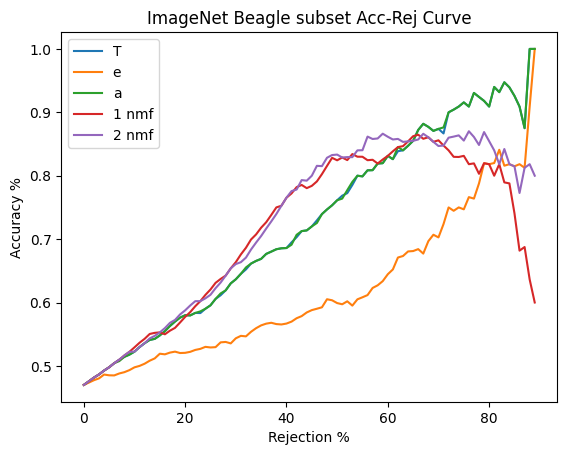

In [3]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["raw-local-1-imp"], label="1 soft imp")

# plt.plot(steps ,results[0]["raw-local-1-imp"], label="1 hard imp")

plt.plot(steps , results[0]["raw-local-1-nmf"], label="1 nmf")

plt.plot(steps ,results[0]["raw-local-2-nmf"], label="2 nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

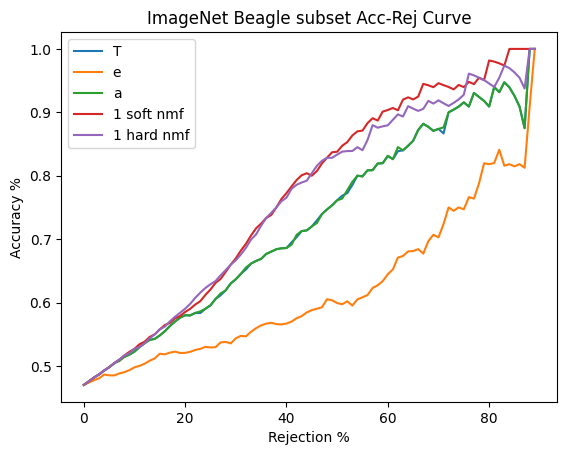

In [7]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["soft_weighted-local-1-imp"], label="1 soft imp")

# plt.plot(steps ,results[0]["hard_weighted-local-1-imp"], label="1 hard imp")

plt.plot(steps , results[0]["soft_weighted-local-1-nmf"], label="1 soft nmf")

plt.plot(steps ,results[0]["hard_weighted-local-1-nmf"], label="1 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

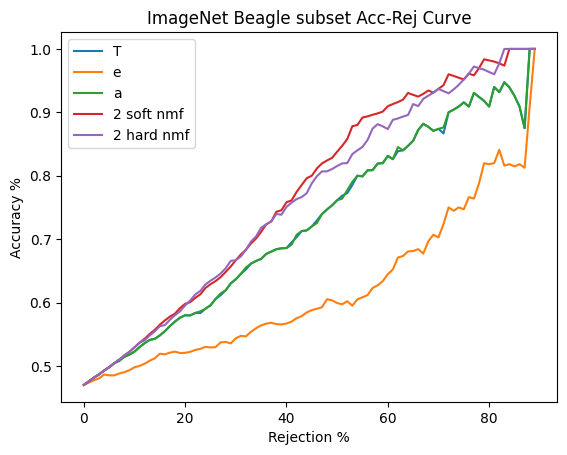

In [8]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["soft_weighted-local-2-imp"], label="2 soft imp")

# plt.plot(steps ,results[0]["hard_weighted-local-2-imp"], label="2 hard imp")

plt.plot(steps , results[0]["soft_weighted-local-2-nmf"], label="2 soft nmf")

plt.plot(steps ,results[0]["hard_weighted-local-2-nmf"], label="2 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

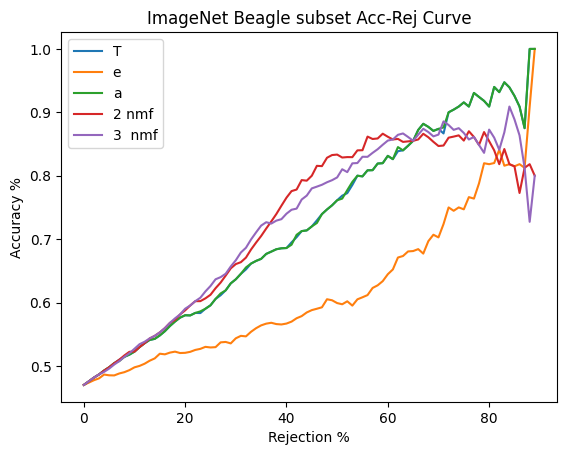

In [9]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["raw-local-2-imp"], label="2 soft imp")

# plt.plot(steps ,results[0]["raw-local-1-imp"], label="1 hard imp")

plt.plot(steps , results[0]["raw-local-2-nmf"], label="2 nmf")

plt.plot(steps ,results[0]["raw-local-3-nmf"], label="3  nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

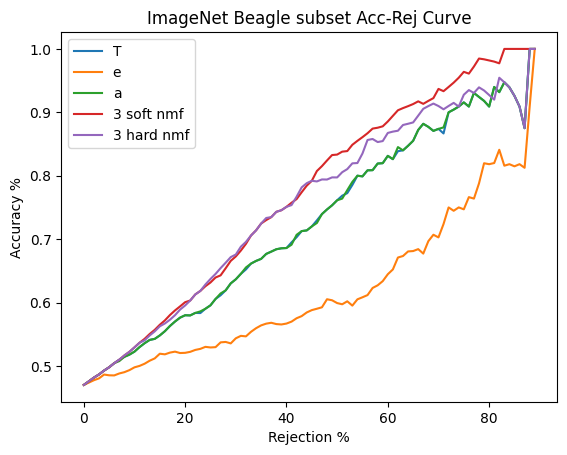

In [10]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["soft_weighted-local-3-imp"], label="3 soft imp")

# plt.plot(steps ,results[0]["hard_weighted-local-3-imp"], label="3 hard imp")

plt.plot(steps , results[0]["soft_weighted-local-3-nmf"], label="3 soft nmf")

plt.plot(steps ,results[0]["hard_weighted-local-3-nmf"], label="3 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

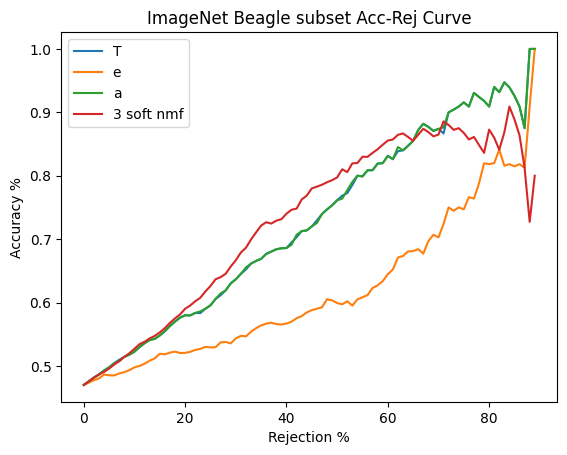

In [11]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["raw-local-3-imp"], label="3 soft imp")

# plt.plot(steps ,results[0]["raw-local-1-imp"], label="1 hard imp")

plt.plot(steps , results[0]["raw-local-3-nmf"], label="3 soft nmf")

# plt.plot(steps ,results[0]["raw-local-1-nmf"], label="1 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

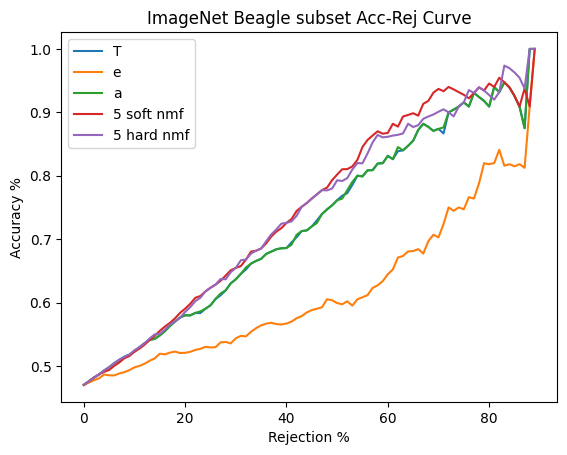

In [12]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["soft_weighted-local-5-imp"], label="5 soft imp")

# plt.plot(steps ,results[0]["hard_weighted-local-5-imp"], label="5 hard imp")

plt.plot(steps , results[0]["soft_weighted-local-5-nmf"], label="5 soft nmf")

plt.plot(steps ,results[0]["hard_weighted-local-5-nmf"], label="5 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

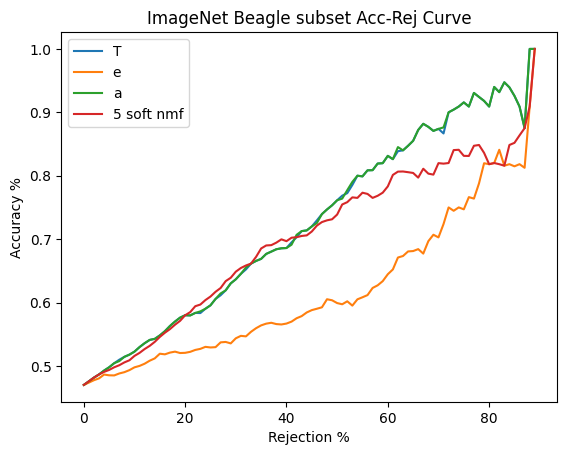

In [15]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["raw-local-5-imp"], label="5 soft imp")

# plt.plot(steps ,results[0]["raw-local-1-imp"], label="1 hard imp")

plt.plot(steps , results[0]["raw-local-5-nmf"], label="5 soft nmf")

# plt.plot(steps ,results[0]["raw-local-1-nmf"], label="1 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()

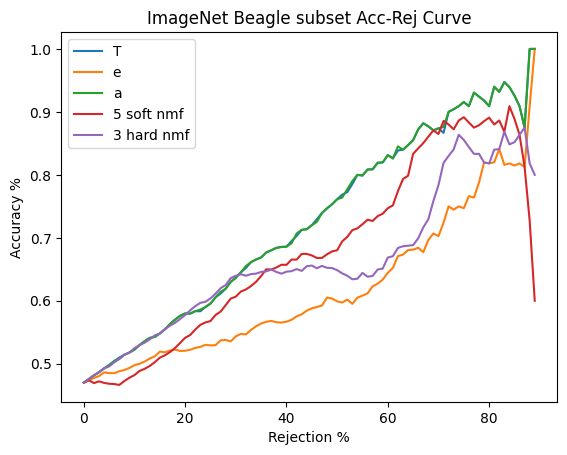

In [16]:
steps = list(range(90))

plt.plot(steps ,results[0]["total"], label="T")

plt.plot(steps , results[0]["epistemic"], label="e")

plt.plot(steps , results[0]["aleatoric"], label="a")

# plt.plot(steps , results[0]["raw-global-5-imp"], label="5 soft imp")

# plt.plot(steps ,results[0]["raw-global-3-imp"], label="3 hard imp")

plt.plot(steps , results[0]["raw-global-5-nmf"], label="5 soft nmf")

plt.plot(steps ,results[0]["raw-global-3-nmf"], label="3 hard nmf")


plt.xlabel('Rejection %')
plt.ylabel('Accuracy %') 
plt.title('ImageNet Beagle subset Acc-Rej Curve')
plt.legend()
# plt.savefig("./figures/"+ task + "/fine_tuned/epistemic_ent.png")
plt.show()